# RNN usage in text processing

### Read Libraries

In [1]:
pip install emoji_translate

     |████████████████████████████████| 430kB 28.6MB/s 
     |████████████████████████████████| 133kB 44.5MB/s 


In [2]:
pip install pyspellchecker

     |████████████████████████████████| 2.7MB 30.9MB/s 


In [3]:
import pandas as pd
import numpy as np
import re
from emoji_translate.emoji_translate import Translator
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN, SMOTE
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read data

In [4]:
tweets = pd.read_csv('/content/sentiment_final.csv')
tweets.head()

,text,sentiment
0,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
1,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
2,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
3,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
4,RT @warriorwoman91: I liked her and was happy ...,Negative


### Data Preprocessing

In [5]:
emo = Translator(exact_match_only=False, randomize=True)
def preprocess(tweet):
  # Lower casing
  processed_tweet = tweet.lower()
  # Removal of URLs
  processed_tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', processed_tweet)
  # Removal of $stocksymbol
  processed_tweet = re.sub('\$[a-zA-Z0-9_]*', ' ', processed_tweet)
  # Removal of RT
  processed_tweet = re.sub('rt \@[a-zA-Z0-9_]*', ' ', processed_tweet)
  # Removal of @username
  processed_tweet = re.sub('\@[a-zA-Z0-9_]*', ' ', processed_tweet)
  # Conversion of emojis to words
  processed_tweet = emo.demojify(processed_tweet)
  # Removal of Punctuations
  processed_tweet = re.sub('[^a-zA-Z\']', ' ', processed_tweet)
  # Removal of single letter words
  processed_tweet = ' '.join( [w for w in processed_tweet.split() if len(w)>1] )
  return processed_tweet

In [6]:
processed_tweets = tweets.copy()
processed_tweets['text'] = tweets.apply(lambda tweet: preprocess(tweet['text']), axis=1)

processed_tweets

,text,sentiment
0,didn't catch the full gopdebate last night her...,Positive
1,that carly fiorina is trending hours after her...,Positive
2,gopdebate delivered the highest ratings in the...,Positive
3,on my first day will rescind every illegal exe...,Positive
4,liked her and was happy when heard she was goi...,Negative
...,...,...
10724,love to see men who will never be faced with p...,Negative
10725,who thought huckabee exceeded their expectatio...,Positive
10726,tedcruz as president will always tell the trut...,Positive
10727,gopdebate donald trump says that he doesn't ha...,Negative


In [7]:
stop_words = set(stopwords.words('english'))
spell = SpellChecker()
def tokenize(text):
  words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
  words = [word for word in words if (word not in stop_words)]
  wnl = nltk.stem.WordNetLemmatizer()
  words = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
  # words = [spell.correction(word) for word in words]
  return words

In [8]:
tokenized_tweets = processed_tweets.copy()
tokenized_tweets['text'] = processed_tweets.apply(lambda tweet: tokenize(tweet['text']), axis=1)
tokenized_tweets

,text,sentiment
0,"[catch, full, gopdebate, last, night, scott, b...",Positive
1,"[carly, fiorina, trend, hour, debate, men, com...",Positive
2,"[gopdebate, deliver, highest, rat, history, pr...",Positive
3,"[first, day, rescind, every, illegal, executiv...",Positive
4,"[like, happy, hear, go, moderator, anymore, go...",Negative
...,...,...
10724,"[love, see, men, never, face, pregnancy, talk,...",Negative
10725,"[think, huckabee, exceed, expectation, gopdeba...",Positive
10726,"[tedcruz, president, always, tell, truth, say,...",Positive
10727,"[gopdebate, donald, trump, say, time, politica...",Negative


In [9]:
processed_tweets['text'] = tokenized_tweets['text'].apply(lambda tokens: " ".join(tokens))
processed_tweets

,text,sentiment
0,catch full gopdebate last night scott best lin...,Positive
1,carly fiorina trend hour debate men complete g...,Positive
2,gopdebate deliver highest rat history presiden...,Positive
3,first day rescind every illegal executive acti...,Positive
4,like happy hear go moderator anymore gopdebate,Negative
...,...,...
10724,love see men never face pregnancy talk body re...,Negative
10725,think huckabee exceed expectation gopdebate im...,Positive
10726,tedcruz president always tell truth say would ...,Positive
10727,gopdebate donald trump say time political corr...,Negative


### Split Data

In [10]:
final_features_df = processed_tweets.copy().drop(['sentiment'], axis=1)
final_features_df

,text
0,catch full gopdebate last night scott best lin...
1,carly fiorina trend hour debate men complete g...
2,gopdebate deliver highest rat history presiden...
3,first day rescind every illegal executive acti...
4,like happy hear go moderator anymore gopdebate
...,...
10724,love see men never face pregnancy talk body re...
10725,think huckabee exceed expectation gopdebate im...
10726,tedcruz president always tell truth say would ...
10727,gopdebate donald trump say time political corr...


In [11]:
final_target_df = pd.DataFrame(processed_tweets['sentiment'], columns=['sentiment'])
final_target_df['sentiment'] = np.where(final_target_df['sentiment']=='Positive', 1, 0)
final_target_df

,sentiment
0,1
1,1
2,1
3,1
4,0
...,...
10724,0
10725,1
10726,1
10727,0


In [12]:
train_valid_x, test_x, train_valid_y, test_y = train_test_split(final_features_df, final_target_df, test_size=0.2, random_state=42)

In [13]:
train_x, valid_x, train_y, valid_y = train_test_split(train_valid_x, train_valid_y, test_size=0.1, random_state=42)

In [14]:
print(len(train_x))
print(len(test_x))
print(len(valid_x))

7724
2146
859


### Data Balancing

In [15]:
pip install nlpaug

     |████████████████████████████████| 399kB 33.0MB/s 


In [16]:
classes = processed_tweets['sentiment'].unique()
classes

array(['Positive', 'Negative'], dtype=object)

In [17]:
positive_train_tweets = train_y == 1
print(f"Positive train tweets count: {positive_train_tweets.sum()}")
negative_train_tweets = train_y == 0
print(f"Negative train tweets count: {negative_train_tweets.sum()}")

Positive train tweets count: sentiment    1627
dtype: int64
Negative train tweets count: sentiment    6097
dtype: int64


In [18]:
values = [positive_train_tweets.sum()[0], negative_train_tweets.sum()[0]]
values

[1627, 6097]

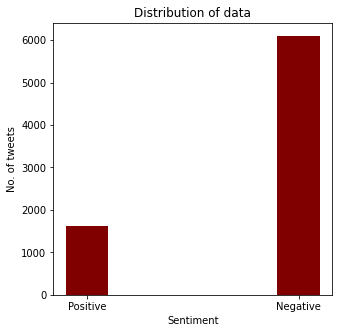

In [19]:
fig = plt.figure(figsize = (5, 5))

plt.bar(classes, values, color ='maroon',
        width = 0.2)
 
plt.xlabel("Sentiment")
plt.ylabel("No. of tweets")
plt.title("Distribution of data")
plt.show()

In [20]:
import nlpaug
import nlpaug.augmenter.word as naw

In [21]:
train_all_df = train_x.copy()
train_all_df['sentiment'] = train_y
train_all_df

,text,sentiment
8490,jeb bush remind elevator music hear listen u g...,0
754,forget vote especislly go independent lulz huc...,1
9650,one take seriously gopdebates,0
583,pretty impress rubio kasich cruz primetime deb...,1
3215,yep horrible stuff say gopdebate show low gop ...,0
...,...,...
5275,gopdebate make pump politics next year noshame...,1
7413,watch gopdebates ca help think claire underwoo...,0
7558,dr carson remark dc half brain best line gopde...,1
748,get ta love gopdebate,1


In [22]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=2)

In [23]:
augmented_data = []
train_all_df[train_all_df['sentiment']==1]['text'].apply(lambda tweet: augmented_data.extend(aug.augment(tweet, 2)))
print(len(augmented_data))


3254


In [24]:
augmented_df = pd.DataFrame(np.array([augmented_data, np.ones(len(augmented_data), dtype=int)]).T,
                   columns=['text', 'sentiment'])
augmented_df

,text,sentiment
0,forget vote especislly go main lulz huckster r...,1
1,forget vote especislly go self governing lulz ...,1
2,pretty impress rubio kasich cruz primetime deb...,1
3,pretty impress rubio kasich cruz primetime arg...,1
4,excellent wow stopcommoncore commoncorenews ho...,1
...,...,...
3249,dr kit carson remark dc half brain good line g...,1
3250,acquire ta love gopdebate,1
3251,get ta love gopdebate,1
3252,modest bar set mostly impress ability turn lik...,1


In [25]:
train_all_df = train_all_df.append(augmented_df, ignore_index=True)
train_all_df = train_all_df.sample(frac=1).reset_index(drop=True)
train_all_df

,text,sentiment
0,gopdebate anything debate way many stage make ...,0
1,stand woman stand life ted pregnant pause cruz...,0
2,fox news obviously try influence makeup republ...,0
3,anyone else want punch chris wallace face gopd...,0
4,file subject overlook gopdebate,0
...,...,...
10973,would love check matchup carly hillary gopdebates,1
10974,slay gopdebate ask think provoke question clap...,1
10975,gopdebate feelthebern step fall hillary justic...,1
10976,fox news wo admit republican leader right mean...,0


In [26]:
train_x = train_all_df.drop(['sentiment'], axis=1)
train_x

,text
0,gopdebate anything debate way many stage make ...
1,stand woman stand life ted pregnant pause cruz...
2,fox news obviously try influence makeup republ...
3,anyone else want punch chris wallace face gopd...
4,file subject overlook gopdebate
...,...
10973,would love check matchup carly hillary gopdebates
10974,slay gopdebate ask think provoke question clap...
10975,gopdebate feelthebern step fall hillary justic...
10976,fox news wo admit republican leader right mean...


In [27]:
train_y = pd.DataFrame(train_all_df['sentiment'].astype(int))
train_y

,sentiment
0,0
1,0
2,0
3,0
4,0
...,...
10973,1
10974,1
10975,1
10976,0


In [28]:
positive_train_tweets = train_y == 1
print(f"Positive train tweets count: {positive_train_tweets.sum()}")
negative_train_tweets = train_y == 0
print(f"Negative train tweets count: {negative_train_tweets.sum()}")

Positive train tweets count: sentiment    4881
dtype: int64
Negative train tweets count: sentiment    6097
dtype: int64


### Use Bert 

In [29]:
pip install transformers

     |████████████████████████████████| 2.5MB 34.6MB/s 
     |████████████████████████████████| 901kB 46.3MB/s 
     |████████████████████████████████| 3.3MB 43.3MB/s 


In [30]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

In [31]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
train_lengths = train_x['text'].apply(lambda tweet: len(tokenizer.encode(tweet, max_length=512)))
train_lengths

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0        21
1        18
2        20
3        21
4        10
         ..
10973    16
10974    24
10975    25
10976    18
10977    15
Name: text, Length: 10978, dtype: int64

In [33]:
max(train_lengths)

48

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

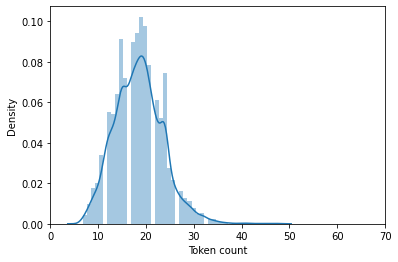

In [34]:
sns.distplot(train_lengths)
plt.xlim([0, 70]);
plt.xlabel('Token count')

In [35]:
max_length = max(train_lengths) + 20

### Prepare DataLoader

In [36]:
batch_size = 32

In [37]:
class TweetDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.tweets)
  def __getitem__(self, item):
    tweet = str(self.tweets[item][0])
    target = int(self.targets[item])
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [38]:
def create_data_loader(df_x, df_y, tokenizer, max_len, batch_size):
  ds = TweetDataset(
    tweets=df_x.to_numpy(),
    targets=df_y.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [39]:
train_loader = create_data_loader(train_x, train_y, tokenizer, max_length, batch_size)
test_loader = create_data_loader(test_x, test_y, tokenizer, max_length, batch_size)
valid_loader = create_data_loader(valid_x, valid_y, tokenizer, max_length, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
data = next(iter(train_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 68])
torch.Size([32, 68])
torch.Size([32])


### Network

In [43]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()          
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 64)
        self.fc2 = nn.Linear(64, n_classes)
        self.act = nn.ReLU()
        self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
        self.fc3 = nn.Linear(256*2, n_classes)
  
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = output['pooler_output']
        output = self.drop(output)
        output = self.fc(output) 
        # output = self.act(output)
        # output = self.fc2(output)
        return output
        # bert_out = self.bert(
        #        input_ids, 
        #        attention_mask)
        # sequence_output = bert_out['last_hidden_state']
        # pooled_output = bert_out['pooler_output']

        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        # lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
        # hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
        # linear_output = self.fc3(hidden.view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

        # return linear_output
    

### Train and Test

In [44]:
from tqdm import tqdm
from tqdm import trange
def train(model, train_loader, test_loader, epochs_num, optimizer, loss_function, train_size, test_size):
  epochs_train_loss = []
  epochs_test_loss = []
  epochs_train_acc = []
  epochs_test_acc = []
  for epoch in trange(1, epochs_num+1, desc ="Epoch loop"):
    batches_train_loss = []
    batches_train_predictions = []
    batches_train_targets = []
    for index, data in tqdm(enumerate(train_loader), desc ="Iteration loop"):
      input_ids = data["input_ids"].cuda()
      attention_mask = data["attention_mask"].cuda()
      targets = data["targets"].cuda()

      optimizer.zero_grad()
      output = model(input_ids, attention_mask)
      _, prediction = torch.max(output, 1)

      loss = loss_function(output, targets.flatten())

      loss.backward()
      optimizer.step()

      batches_train_loss.append(loss.item())

      batches_train_predictions.extend(prediction.cpu())
      batches_train_targets.extend(targets.cpu())
    
    batches_test_predictions, batches_test_targets, batches_test_loss = test(model, test_loader, optimizer, loss_function)
    epochs_train_acc.append(accuracy_score(batches_train_targets, batches_train_predictions))
    epochs_train_loss.append(np.sum(batches_train_loss)/train_size)

    epochs_test_acc.append(accuracy_score(batches_test_targets, batches_test_predictions))
    epochs_test_loss.append(np.sum(batches_test_loss)/test_size)

    print('Epoch {} is finished!'.format(epoch))
  return epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc

In [45]:
def test(model, test_loader, optimizer, loss_function):
  batches_test_loss = []
  batches_test_predictions = []
  batches_test_targets = []
  with torch.no_grad():
    for data in test_loader:
      input_ids = data["input_ids"].cuda()
      attention_mask = data["attention_mask"].cuda()
      targets = data["targets"].cuda()

      output = model(input_ids, attention_mask)
      _, prediction = torch.max(output, 1)
      loss = loss_function(output, targets.flatten()).item()
      batches_test_loss.append(loss)
      batches_test_predictions.extend(prediction.cpu())
      batches_test_targets.extend(targets.cpu())
    
  return batches_test_predictions, batches_test_targets, batches_test_loss

### Plot Result

In [46]:
def plot_result(epochs_train, epochs_valid, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'valid']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train)
  plt.plot(x_axis, epochs_valid)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

### Run Model

In [47]:
feature_size = train_x.shape[1]

In [158]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [147]:
model = Classifier(2)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [49]:
#[1627, 6097]
weights = [1/6097, 1/1627]
weights

[0.0001640150893882237, 0.0006146281499692685]

In [150]:
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights)).cuda()
# criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8)

In [151]:
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(model, train_loader, valid_loader, 5, optimizer, criterion, len(train_x), len(valid_x))

Epoch loop:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 

Epoch 1 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 2 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 3 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 4 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 5 is finished!


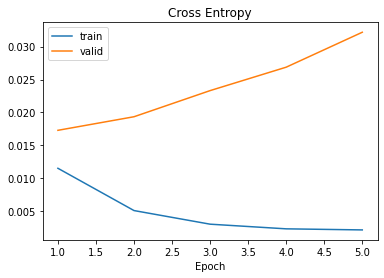

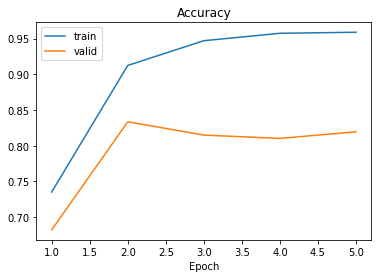

In [152]:
plot_result(epochs_train_loss, epochs_test_loss, 5, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 5, "Accuracy")

In [153]:
batches_test_predictions, batches_test_targets, batches_test_loss = test(model, test_loader, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [154]:
print(classification_report(batches_test_targets, batches_test_predictions))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1713
           1       0.57      0.70      0.63       433

    accuracy                           0.83      2146
   macro avg       0.74      0.78      0.76      2146
weighted avg       0.85      0.83      0.84      2146



Text(0.5, 15.0, 'Predicted')

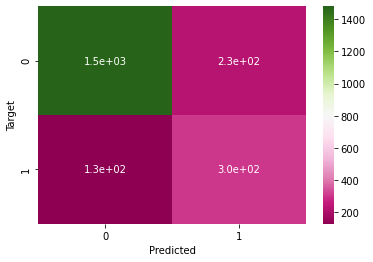

In [155]:
sns.heatmap(confusion_matrix(batches_test_targets, batches_test_predictions), annot=True, cmap='PiYG')
plt.ylabel('Target')
plt.xlabel('Predicted')

In [179]:
model = Classifier(2)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [180]:
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights)).cuda()
# criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8)

In [181]:
epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc = train(model, train_loader, valid_loader, 5, optimizer, criterion, len(train_x), len(valid_x))

Epoch loop:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 

Epoch 1 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 2 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 3 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 4 is finished!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch 5 is finished!


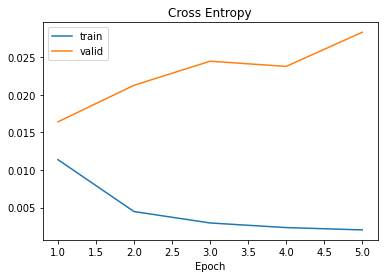

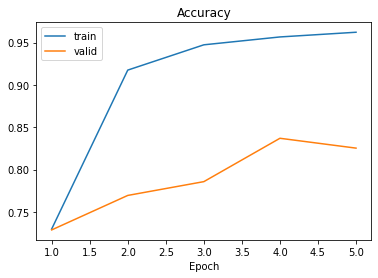

In [182]:
plot_result(epochs_train_loss, epochs_test_loss, 5, "Cross Entropy")
plot_result(epochs_train_acc, epochs_test_acc, 5, "Accuracy")

In [183]:
batches_test_predictions, batches_test_targets, batches_test_loss = test(model, test_loader, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [184]:
print(classification_report(batches_test_targets, batches_test_predictions))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1713
           1       0.53      0.68      0.60       433

    accuracy                           0.82      2146
   macro avg       0.72      0.76      0.74      2146
weighted avg       0.84      0.82      0.82      2146



Text(0.5, 15.0, 'Predicted')

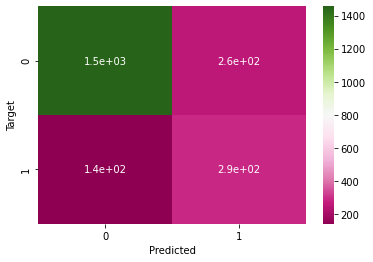

In [185]:
sns.heatmap(confusion_matrix(batches_test_targets, batches_test_predictions), annot=True, cmap='PiYG')
plt.ylabel('Target')
plt.xlabel('Predicted')

In [48]:
model = Classifier(2)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 